# 02. Embedding and Similarity

This notebook encodes both resume and job description text into numerical representations using a Sentence Transformer model `(all-MiniLM-L6-v2)`. These embeddings capture semantic relationships between words and phrases, enabling the model to understand meaning beyond surface-level keywords.

After preprocessing and cleaning, embeddings for all jobs and the uploaded resume are computed. The notebook then uses cosine similarity to compare the resume vector against every job vector, identifying those most semantically aligned. The higher the cosine similarity score, the closer the match between the candidate’s experience and the job’s requirements.

In [39]:
!pip install --upgrade pip

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [40]:
!pip install ipykernel jupyter sentence-transformers torch scikit-learn pandas numpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [41]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [42]:
!pip install -U "ml_dtypes>=0.5"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Import Libraries

In [43]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

## Load Cleaned Data

In [44]:
resumes = pd.read_csv('../data/cleaned_resumes_for_model.csv')
jobs = pd.read_csv('../data/cleaned_jobs_for_model.csv')

resumes.head(), jobs.head()

print("Resume columns:", resumes.columns)
print("Job dataset columns:", jobs.columns)

Resume columns: Index(['ID', 'Resume_str', 'Resume_html', 'Category', 'clean_resume',
       'clean_resume_display'],
      dtype='object')
Job dataset columns: Index(['source', 'id', 'title', 'company', 'location', 'description', 'url',
       'salary_min', 'salary_max', 'date_posted', 'clean_job',
       'clean_job_display'],
      dtype='object')


## Load Pre-Trained Model

In [45]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

## Generate Embeddings

In [46]:
# Encode resumes and jobs 
resume_embeddings = model.encode(resumes['clean_resume'].tolist(), show_progress_bar=True)
job_embeddings = model.encode(jobs['clean_job'].tolist(), show_progress_bar=True)

print("Embeddings generated successfully!")

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Batches:   0%|          | 0/367 [00:00<?, ?it/s]

Embeddings generated successfully!


In [47]:
# Normalize embeddings to unit vectors for cosine similarity
resume_embeddings = resume_embeddings / np.linalg.norm(resume_embeddings, axis=1, keepdims=True)
job_embeddings = job_embeddings / np.linalg.norm(job_embeddings, axis=1, keepdims=True)

In [48]:
# Save embeddings for later use

np.save('../data/resume_embeddings.npy', resume_embeddings)
np.save('../data/job_embeddings.npy', job_embeddings)
print("Embeddings saved successfully!")

Embeddings saved successfully!


## Compute Similarity

In [49]:
similarity_matrix = cosine_similarity(resume_embeddings, job_embeddings)

## Find Top Matches

In [50]:
import numpy as np

# Show top N matches for the first few resumes
top_n = 5

for i, resume in enumerate(resumes["clean_resume"].head(3)):
    top_indices = np.argsort(-similarity_matrix[i])[:top_n]
    print(f"\nTop {top_n} job matches for Resume {i+1}:")
    for idx in top_indices:
        title = jobs.loc[idx, "title"] if "title" in jobs.columns else "Unknown Title"
        company = jobs.loc[idx, "company"] if "company" in jobs.columns else ""
        score = similarity_matrix[i][idx]
        print(f" - {title} at {company} (Score: {score:.4f})")


Top 5 job matches for Resume 1:
 - People Operations Generalist at Evapco (Score: 0.7453)
 - HR and People Operations Coordinator at F&M Bank - Archbold, OH (Score: 0.7382)
 - People Operations Manager at Hive (Score: 0.7377)
 - People Operations (HR) Manager at Pathpoint (Score: 0.7356)
 - People Operations Manager at Nabors (Score: 0.7344)

Top 5 job matches for Resume 2:
 - HR and People Operations Coordinator at F&M Bank - Archbold, OH (Score: 0.8009)
 - People Operations (HR) Business Partner at Niowave (Score: 0.7928)
 - People Operations (HR) Manager at Pathpoint (Score: 0.7927)
 - People Operations Associate at Verkada (Score: 0.7872)
 - People Operations Generalist at Hive (Score: 0.7836)

Top 5 job matches for Resume 3:
 - People Operations (HR) Manager at Pathpoint (Score: 0.8204)
 - People Operations Generalist - HR at Amity Foundation (Score: 0.8161)
 - Director of People Operations at Reema Health (Score: 0.8139)
 - People Operations Assistant at Childhelp (Score: 0.8108

In [51]:
jobs_clean = pd.read_csv('../data/cleaned_jobs_full.csv')
print("Total jobs:", len(jobs_clean))
print("Unique job titles:", jobs_clean['title'].nunique())

Total jobs: 11734
Unique job titles: 2867


In [54]:
import sys, os
sys.path.append(os.path.abspath(".."))

from src.recommender import JobRecommender
from src.embedder import ResumeJobEmbedder

# Load saved data and embeddings
resumes_model = pd.read_csv("../data/cleaned_resumes_for_model.csv")
resumes_display = pd.read_csv("../data/cleaned_resumes_full.csv")
jobs = pd.read_csv("../data/cleaned_jobs_for_model.csv")
job_embeddings = np.load("../data/job_embeddings.npy")

# Initialize recommender and embedder
recommender = JobRecommender(job_embeddings, jobs)
embedder = ResumeJobEmbedder(model_name="all-MiniLM-L6-v2")

# Select a sample resume
resume_text = resumes_model.loc[0, "clean_resume"]

# Generate top match explanation
results_df = recommender.recommend(resume_text, embedder, top_k=3)
print(results_df[['title', 'similarity_score']])

explanation = recommender.explain_top_match(resume_text, embedder)
print(explanation)

Loading embedding model: all-MiniLM-L6-v2
Encoding resume...
Finding top 3 matches...
                                  title  similarity_score
0          People Operations Generalist          0.745336
1  HR and People Operations Coordinator          0.738222
2             People Operations Manager          0.737750
Encoding resume...
Finding top 1 matches...
{'job_title': 'People Operations Generalist', 'similarity_score': np.float32(0.745336), 'shared_skills': ['associate', 'company', 'missouri', 'senior', 'support', 'team'], 'missing_skills': ['air', 'berkeley', 'better', 'boeing', 'collaborate', 'committed', 'currently', 'description', 'engineersdevelopers', 'environment', 'experienced', 'focus', 'fostering', 'future', 'great', 'growth', 'inclusive', 'innovate', 'job', 'located'], 'extra_skills': ['absence', 'accomplished', 'accomplishment', 'accounting', 'accuracy', 'activity', 'administers', 'administration', 'administrator', 'administratormarketing', 'advanced', 'advertising', '

In [55]:
# Display results with dynamic wrapping based on terminal size

import textwrap
import shutil

def wrap_text_auto(text, padding=10):
    """Wrap text dynamically based on terminal width."""
    try:
        width = shutil.get_terminal_size().columns - padding
        if width < 40:
            width = 40  # minimum width fallback
    except OSError:
        width = 80  # fallback for environments like Jupyter
    return "\n".join(textwrap.wrap(text, width=width))

results_df = recommender.recommend(resume_text, embedder, top_k=3)
print(results_df[['title', 'similarity_score']])

print("=" * 80)
print(f"Top Match: {explanation['job_title']}")
print(f"Similarity Score: {explanation['similarity_score']:.2f}\n")

print("Resume (display version):")
resume_preview = resumes_model.loc[0, 'clean_resume_display']
print(wrap_text_auto(resume_preview), "\n")

print("Shared Skills:")
print(wrap_text_auto(", ".join(explanation['shared_skills'])))

print("\nMissing Skills:")
print(wrap_text_auto(", ".join(explanation['missing_skills'])))

print("\nExtra Skills in Resume:")
print(wrap_text_auto(", ".join(explanation['extra_skills'])))
print("=" * 80)


Encoding resume...
Finding top 3 matches...
                                  title  similarity_score
0          People Operations Generalist          0.745336
1  HR and People Operations Coordinator          0.738222
2             People Operations Manager          0.737750
Top Match: People Operations Generalist
Similarity Score: 0.75

Resume (display version):
Hr administrator/marketing associate hr administrator summary
dedicated customer service manager with 15+ years of experience in
hospitality and customer service management. Respected builder and
leader of customer-focused teams; strives to instill a shared,
enthusiastic commitment to customer service. Highlights focused on
customer satisfaction team management marketing savvy conflict
resolution techniques training and development skilled multi-tasker
client relations specialist accomplishments missouri dot supervisor
training certification certified by ihg in customer loyalty and
marketing by segment hilton worldwide general

## Visualization

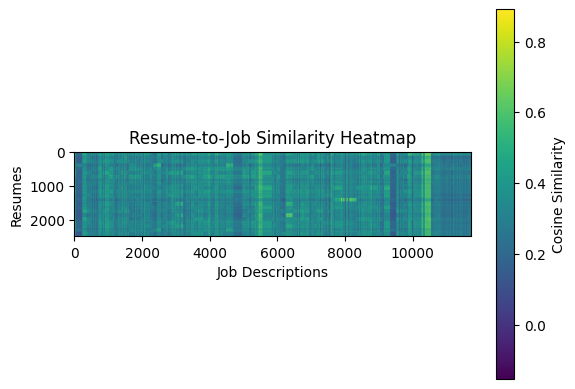

In [56]:
import matplotlib.pyplot as plt

plt.imshow(similarity_matrix, cmap='viridis')
plt.title("Resume-to-Job Similarity Heatmap")
plt.xlabel("Job Descriptions")
plt.ylabel("Resumes")
plt.colorbar(label="Cosine Similarity")
plt.show()

## Summary

This notebook prepares the foundation for job–resume matching by transforming all text data into numerical vectors. Using the `all-MiniLM-L6-v2` Sentence Transformer, it generates embeddings for both resumes and job descriptions, then normalizes them into unit vectors to ensure cosine similarity is based purely on direction, not magnitude.

After normalization, the embeddings are saved as `.npy` files (`resume_embeddings.npy` and `job_embeddings.npy`) for efficient reuse in later steps of the pipeline. These saved files will be loaded in the next stage to calculate similarity scores and identify top job matches.

In short, this step converts text into normalized, reusable embeddings - making it possible to quantitatively compare resumes and jobs in the next phase.